Binomial Method Bermudan Option pricing

In [68]:
import matplotlib.pyplot as plt
import numpy as np

In [69]:
def binomial_tree_stock(S, T, sigma, n):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    
    stock_tree = np.zeros((n + 1, n + 1))
    stock_tree[0, 0] = S
    
    for i in range(1, n + 1):
        stock_tree[i, i] = stock_tree[i - 1, i - 1] * u
        for j in range(i, n + 1):
            stock_tree[j, i - 1] = stock_tree[j - 1, i - 1] * d
            
    return stock_tree


# payoff function for call or puts with stock price S and strike price K
def payoff(S, K, style):
    if style == 'call':
        return max(S - K, 0)
    elif style == 'put':
        return max(K - S, 0)
    else:
        raise ValueError("Invalid option style. Style must be 'call' or 'put'.")


def binomial_bermudan_option_pricing(S, K, T, r, sigma, n, early_exercise_dates, style):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize option value matrix
    option_values = np.zeros((n + 1, n + 1))

    # Calculate the option values at expiration
    for i in range(n + 1):
        option_values[n][i] = payoff(S * (u ** i) * (d ** (n - i)), K, style)

    # Calculate the option values at earlier exercise dates
    for t in range(n - 1, -1, -1):
        for i in range(t + 1):
            hold_value = np.exp(-r * dt) * (p * option_values[t + 1][i+1] + (1 - p) * option_values[t + 1][i])
            if round(t * dt,2) in early_exercise_dates:
                option_values[t][i] = max(payoff(S * (u ** i) * (d ** (t - i)), K, style), hold_value)
            else:
                option_values[t][i] = hold_value

    return option_values


def binomial_american_option_pricing(S, K, T, r, sigma, n, style):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize option value matrix
    option_values = np.zeros((n + 1, n + 1))

    # Calculate the option values at expiration
    for i in range(n + 1):
        option_values[n][i] = payoff(S * (u ** i) * (d ** (n - i)), K, style)

    # Calculate the option values at earlier exercise dates
    for t in range(n - 1, -1, -1):
        for i in range(t + 1):
            hold_value = np.exp(-r * dt) * (p * option_values[t + 1][i+1] + (1 - p) * option_values[t + 1][i])
            option_values[t][i] = max(payoff(S * (u ** i) * (d ** (t - i)), K, style), hold_value)

    return option_values


def binomial_delta(option_values, sigma, T, n, S):
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    
    delta=np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1):
            delta[i][j] = (option_values[i + 1][j + 1] - option_values[i + 1][j]) / (S * (d ** (i - j)) * (u ** (j + 1)) - S * (d ** (i + 1 - j)) * (u ** j))
            
    return delta
    

In [70]:
S0 = 100   # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity
r = 0.05  # Risk-free interest rate
sigma = 0.3  # Volatility
n = 100   # Number of time steps in the binomial tree
early_exercise_dates = [0.3, 0.8]  # List of early exercise dates

bermudan_option_prices = binomial_bermudan_option_pricing(S0, K, T, r, sigma, n, early_exercise_dates, 'put')
american_option_prices = binomial_american_option_pricing(S0, K, T, r, sigma, n, 'put')
print("Bermudan Option Price:", bermudan_option_prices[0][0], "American Option Price:", american_option_prices[0][0])

Bermudan Option Price: 9.637074442997404 American Option Price: 9.855994691335153


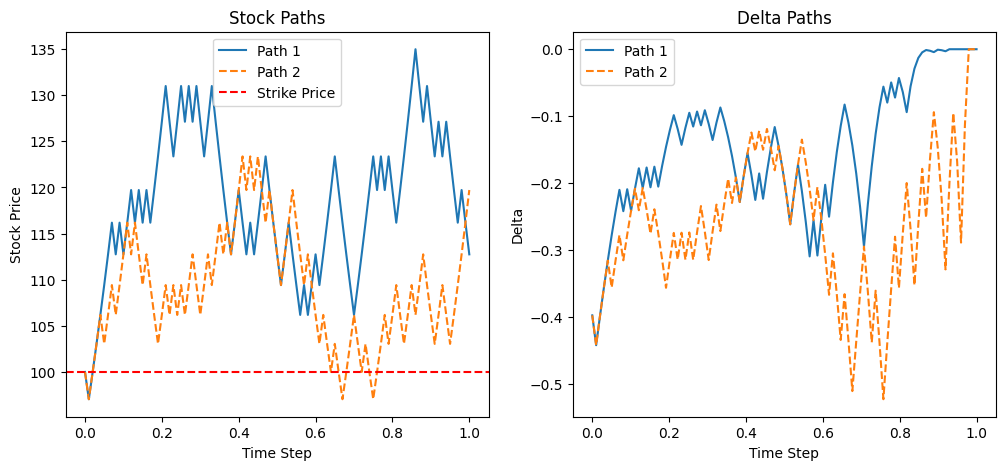

In [71]:
dt = T / n
u = np.exp(sigma * np.sqrt(dt))
d = 1 / u
p = (np.exp(r * dt) - d) / (u - d)

stock = binomial_tree_stock(S0, T, sigma, n)

def sample_path(stock, delta, p):
    
    n = len(stock[0])
    stock_path = [stock[0][0]]
    delta_path = [delta[0][0]]
    
    j = 0
    for i in range(1, n):
        
        up = np.random.binomial(1, p)
        if up:
            j += 1
            stock_path.append(stock[i][j])
            if i != n - 1:
                delta_path.append(delta[i][j])
        else:
            stock_path.append(stock[i][j])
            if i != n - 1:
                delta_path.append(delta[i][j])
    
    return stock_path, delta_path

bermudan_delta = binomial_delta(bermudan_option_prices, sigma, T, n, S0)
stock_path_1, delta_path_1 = sample_path(stock, bermudan_delta, p)
stock_path_2, delta_path_2 = sample_path(stock, bermudan_delta, p)

time_values_s = np.linspace(0, 1, n + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(time_values_s, stock_path_1, label='Path 1', linestyle='-')
plt.plot(time_values_s, stock_path_2, label='Path 2', linestyle='--')
plt.axhline(y=K, color='r', linestyle='--', label='Strike Price')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.title('Stock Paths')
plt.legend()

time_values_o = np.linspace(0, 1, n)
plt.subplot(1, 2, 2)
plt.plot(time_values_o, delta_path_1, label='Path 1', linestyle='-')
plt.plot(time_values_o, delta_path_2, label='Path 2', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Delta')
plt.title('Delta Paths')
plt.legend()

plt.show()